This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [6]:
import numpy as np
import os
import pylab
import seaborn
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import distance
import json
from collections import OrderedDict
import os.path as osp
import pandas as pd
import copy
import scipy.stats as ss
import sys
DIV_LINE_WIDTH = 50

#legacy compatibility
import teachers.algos as algs
import sys
sys.modules['param_env_utils.imgep_utils'] = algs

In [9]:
# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

def get_all_runs(logdir, condition=None, minlen=12):
    #print(logdir)
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        #print(root)
        if 'progress.txt' in files:
            print(root)
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
                    
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'evaluation return',exp_data[performance])
            data_dict = exp_data.to_dict("list")
            data_dict['total timesteps'] = []
            for e in data_dict['Epoch']:
                data_dict['total timesteps'].append(e * config['steps_per_epoch'])
            data_dict['config'] = config
            #print(config)
                
            nb_epochs = len(data_dict['total timesteps'])
            print(nb_epochs)
            if nb_epochs >= minlen:
                datasets.append(data_dict)

                if 'env_params_save.pkl' in files:
                    env_params_dict = pickle.load( open(os.path.join(root,'env_params_save.pkl'), "rb" ) )
                    for k,v in env_params_dict.items():
                        if k=="env_test_rewards" :#or k=='env_params_train':
                            data_dict[k] = v
                        else:
                            data_dict[k] = None
    print(datasets[-1]['config']['exp_name'])
    return datasets

def get_datasets(rootdir="data/final_corl_exp_complex/"):
    default_colors = ["violet","yellow",'green','black',u'#ff7f0e',
                      "cyan", "pink", u'#1f77b4',"grey","r",
                     "darkorchid","sienna","lightpink","blue","blue","blue", "blue","blue","blu"]
    _, models_list, _ = next(os.walk(rootdir))
    print(models_list)
    for dir_name in models_list.copy():
        if "ignore" in dir_name:
            models_list.remove(dir_name)
    for expe_name in list(labels.keys()):
        if expe_name not in models_list:
            del labels[expe_name]
    
    # setting specific colors for each expe
    for i,m_name in enumerate(models_list):
        if m_name in specific_colors:
            colors[m_name] = specific_colors[m_name]
        else:
            colors[m_name] = default_colors[i]
            
    # setting per-model type colors    
    for i,m_name in enumerate(models_list):
        for m_type, m_color in per_model_colors.items():
            if m_type in m_name:
                colors[m_name] = m_color
        print("extracting data for {}...".format(m_name))
        m_id = m_name
        models_saves[m_id] = OrderedDict()
        if rootdir == "data/final_corl_exp_complex/":
            models_saves[m_id]['data'] = get_all_runs(rootdir+m_name, minlen=400)
        else:
            models_saves[m_id]['data'] = get_all_runs(rootdir+m_name)
        print("done")
        if m_name not in labels:
            if 'gmm' in m_name:
                labels[m_name] = 'ALP-GMM'
            elif 'nmm' in m_name:
                labels[m_name] = 'covar-GMM+alp'
            elif 'riac' in m_name:
                labels[m_name] = 'RIAC'
            elif 'oracle' in m_name:
                labels[m_name] = 'Oracle'
            elif 'rand' in m_name:
                labels[m_name] = 'Random'
            elif 'bmm' in m_name:
                labels[m_name] = 'Covar-GMM'
            else:
                labels[m_name] = m_name

    """
    retrieve all experiences located in "data to vizu" folder
    """

# labels = OrderedDict({'randcontshort29-05':"random short legs",
#         'randcont02-05':"random default legs",
#          'randcontlong29-05':"random long legs",
#          'saggcontshort27-05':"SAC+SAGG short legs",
#          'saggcont02-05':"SAC+SAGG default legs",
#          'saggcontlong27-05':'SAC+SAGG long legs',})
labels = OrderedDict()
per_model_colors = OrderedDict()
# model_colors = {'random': 'grey', 'sgs': u'#d62728', 'amb': u'#1f77b4',
#                 'rmb': u'#ff7f0e', 'rgb':u'#9467bd', 'fc':u'#9467bd' }
per_model_colors = OrderedDict({'oracle':u'#9467bd',
                                'gmm':u'#1f77b4',
                                'nmm':'pink',
                                'bmm':'green',
                                'riac':u'#ff7f0e',
                                'rand':"grey"})
specific_colors = {}
# specific_colors = OrderedDict({'riaccontdefaultcpu21-06':'red',
#                                'gmmcdefaultcpu21-06':"darkblue",
#                                'randh5defaultcpu21-06':'lightgray',
#                                'riach4defaultcpu21-06':"orange",
#                                'randh4defaultcpu21-06':'darkgray',
#                                'randcontdefaultcpu20-06':'dimgray',
#                                'riach5defaultcpu21-06':"gold",
#                                'gmmh5defaultcpu21-06':"skyblue",
#                                'gmmh4defaultcpu21-06':"dodgerblue",
#                                'randcontshort29-05':"skyblue"})
models_saves = OrderedDict()
colors = OrderedDict()
get_datasets()
print(per_model_colors)
if per_model_colors:     #order runs for right legend order
    ordered_labels = OrderedDict()
    for teacher_type in per_model_colors.keys():
        for k,v in labels.items():
            if teacher_type in k:
                ordered_labels[k] = v
    labels = ordered_labels
else:
    for k in models_saves.keys():
        labels[k] = k
        
print(labels)
print(colors)

['gmmplongaic2k02-09', 'randplong19-09', 'oracleplongcpu19-09', 'ignore tmp', 'ignore 19_09', 'ignore', 'ignore final', 'ignore 19_08', 'ignore 18_09', 'bmmplongcpu02-09', 'ignore too many seeds', 'riacplong19-09', 'ignore 02_09']
extracting data for gmmplongaic2k02-09...
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s205
400


/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s209
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s204
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s400
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s106
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s101
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s3
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s8
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s206
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s201
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s202
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s1
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s200
400
data/final_corl_exp_complex/gmmplongaic2k02-09/gmmplongaic2k02-09_s208
400
data/final_corl_exp_complex/gmm

data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s3
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s105
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s204
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s205
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s6
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s101
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s209
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s400
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s103
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s206
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s108
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s106
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s401
400
data/final_corl_exp_complex/bmmplongcpu02-09/bmmplongcpu02-09_s9
400
data/final_c

In [ ]:
# FOR SEQ ENV

def print_top_train_env():
    # PRINT TOP 5 train env
#         print(len(run['env_params_train']['stump_hs']))
#         print(len(run['env_train_rewards']))
        height_thr = 2.9
        max_vals = 3
        train_seqs = run['env_params_train']['seqs'][-501:-1]
        print(len(run['env_params_train']['seqs']))
        #print(run['env_params_train']['seqs'][0])
        print(train_seqs[0])
        return
        train_rewards = run['env_train_rewards'][-500:]
        assert(len(train_seqs) == len(train_rewards))
        top_idx = np.array(train_rewards).argsort()[::-1]
        cpt = 0
        for idx in top_idx:
            if train_rewards[idx] > 230:
                cpt+=1
                print("{}, r={}".format(train_seqs, train_rewards[idx]))
                if cpt == max_vals:
                    break
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100
stats = {}
for i,(m_id,label) in enumerate(labels.items()):
    if "gmmslong" not in m_id:
        continue
    print(m_id)
    runs_data = models_saves[m_id]['data']
#         stats[m_id] = {'mean_nb_mastered':np.zeros((len(runs_data),max_epochs)),
#                       'mean_r_per_t':np.zeros((len(runs_data),size_test_set))}
    #collect raw perfs
    for r,run in enumerate(runs_data):
#         if r is not 0:
#             continue
        models_saves[m_id]['data'][r]['nb_mastered'] = []
        for j in range(len(run['evaluation return'])):#max_epoch):
            test_data = np.array(run['env_test_rewards'][j*size_test_set:(j+1)*(size_test_set)])
            nb_mastered = len(np.where(test_data > mastered_thr)[0])
            models_saves[m_id]['data'][r]['nb_mastered'].append((nb_mastered/50)*100)
            
        print_top_train_env()

In [10]:
# FOR COMPLEX POLY ENV
def extract_env_params(env_goals, order=['poly_ss']):
    #order = ['stump_hs', 'tunnel_hs']
    if order == ['poly_ss']:
        flat_env_params = copy.copy(env_goals[order[0]])
        # map to 2d height and width
        scaling = 14/30.0
        obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
        height_width_params = []
        for params in flat_env_params:
            paired_params = [[params[i],params[i+1]] for i in range(0,len(params),2)]
            #print(paired_params)
            # first recover polygon coordinate
            poly_coord = []
            for i,(b,d) in enumerate(zip(obstacle_polygon, paired_params)):
                #print(paired_params)
                if i != 0 and i != (len(obstacle_polygon)-1):
                    poly_coord.append([(b[0]*scaling) + (d[0]*scaling),
                                      (b[1]*scaling) + (d[1]*scaling)])
                else:
                    poly_coord.append([(b[0] * scaling) + (d[0]*scaling),
                                       (b[1] * scaling)])
            # the find maximal width and height
            poly_coord = np.array(poly_coord)
            min_x = np.min(poly_coord[:,0])
            max_x = np.max(poly_coord[:,0])
            min_y = np.min(poly_coord[:,1])
            max_y = np.max(poly_coord[:,1])
            height_width_params.append([(max_x - min_x)/scaling, (max_y - min_y)/scaling])
        return height_width_params

scaling = 14/30.0
obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100
stats = {}
for i,(m_id,label) in enumerate(labels.items()):
#     if "gmmplong" not in m_id:
#         continue
    runs_data = models_saves[m_id]['data']
    print(m_id + " : " + str(len(runs_data)))
#         stats[m_id] = {'mean_nb_mastered':np.zeros((len(runs_data),max_epochs)),
#                       'mean_r_per_t':np.zeros((len(runs_data),size_test_set))}
    #collect raw perfs
    for r,run in enumerate(runs_data):
#         if r is not 0:
#             continue
        models_saves[m_id]['data'][r]['nb_mastered'] = []
        for j in range(len(run['evaluation return'])):#max_epoch):
            test_data = np.array(run['env_test_rewards'][j*size_test_set:(j+1)*(size_test_set)])
            nb_mastered = len(np.where(test_data > mastered_thr)[0])
            models_saves[m_id]['data'][r]['nb_mastered'].append((nb_mastered/50)*100)

        
        if False:
            tasks =  extract_env_params(run['env_params_test'])
            plt.figure(figsize=(8,8))
            ax = plt.gca()
    #         ax.set_xlim(left=0,right=5)
    #         ax.set_ylim(top=5, bottom=0)
            ax.tick_params(axis='both', which='major', labelsize=20)

            #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
            for k,(rew,t) in enumerate(zip(run['env_test_rewards'][-size_test_set:], tasks[-size_test_set:])):
                if rew >= 230:
                    ax.scatter(t[0], t[1], c="green", s=100, zorder=2)

                else:
                    #pass
                    print('s{}: task:{} rew:{}'.format(runs_data[r]['config']['seed'], np.round(t,2), rew))
                    ax.scatter(t[0], t[1], c="red", s=100, zorder=2)
            ax.set_xlabel('Hexagon width', fontsize=25)
            ax.set_ylabel('Hexagon height', fontsize=25)
            ax.set_aspect('equal', 'box')
            plt.tight_layout()
            plt.savefig("graphics/gmmcomplex_triptic_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))
            plt.show()
#         mean_r_per_t = np.median(stats[m_id]['mean_r_per_t'],axis=0)
#         last_t = extract_env_params(run['env_params_test'],order=['stump_hs', 'ob_sps'])[-size_test_set:]
#         last_t = np.round(last_t,2)
        
        
#         plt.figure(figsize=(4,8))
#         ax = plt.gca()
#         ax.set_xlim(left=0,right=3)
#         ax.set_ylim(top=6, bottom=0)
#         ax.locator_params(axis='x', nbins=5)
#         ax.locator_params(axis='y', nbins=5)
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for m,t in zip(mean_r_per_t, last_t):
#             if m > 230:
#                 ax.scatter(t[0], t[1], c="green", s=100, zorder=2)
#             else:
#                 ax.scatter(t[0], t[1], c="red", s=100, zorder=2)
#                 #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
#         plt.savefig("graphics/mastered_env_{}.png".format(m_id))
#         plt.show()
    
                           
#             print(run['env_params_test']['stump_hs'][0])
#             print(len(run['env_test_rewards']))
#             print(run['Epoch'][-1]*size_test_set)
#             print(list(run))
        #print(np.mean(stats[m_id]['mean_nb_mastered'], axis=0))

oracleplongcpu19-09 : 32
gmmplongaic2k02-09 : 32
bmmplongcpu02-09 : 32
riacplong19-09 : 32
randplong19-09 : 26


In [14]:
#FOR SIMPLE ENV
def extract_env_params(env_goals, order=['stump_hs','stump_ws','stump_rs','ob_sps']):
    #order = ['stump_hs', 'tunnel_hs']
    if len(order) == 1:
        pass #work already done
    if order == ['stump_hs', 'ob_sps']:
        for ep_nb in range(nb_episodes):
                flat_env_params[ep_nb].append(env_goals['ob_sps'][ep_nb]) #ignore variance
    elif order == ['stump_hs','stump_ws','stump_rs','ob_sps']:
        for ep_nb in range(nb_episodes):
            flat_env_params[ep_nb].append(env_goals['stump_ws'][ep_nb][0]) #ignore variance 
            flat_env_params[ep_nb].append(env_goals['stump_rs'][ep_nb][0]) #ignore variance 
            flat_env_params[ep_nb].append(env_goals['ob_sps'][ep_nb]) #ignore variance
    else:
        for ep_nb in range(nb_episodes):
            for i in range(1,len(order)):
                flat_env_params[ep_nb].append(env_goals[order[i]][ep_nb]) #ignore variance 
    return flat_env_params

def print_top_train_env():
    # PRINT TOP 5 train env
#         print(len(run['env_params_train']['stump_hs']))
#         print(len(run['env_train_rewards']))
        height_thr = 2.9
        max_vals = 3
        train_stump_h = run['env_params_train']['stump_hs'][-501:-1]
        train_ob_sp = run['env_params_train']['ob_sps'][-501:-1]
        train_rewards = run['env_train_rewards'][-500:]
        assert(len(train_stump_h) == len(train_rewards))
        top_idx = np.array(train_rewards).argsort()[::-1]
        cpt = 0
        for idx in top_idx:
            if train_rewards[idx] > 320 and train_stump_h[idx][0] > height_thr:
                cpt+=1
                print("[{},{}], r={}".format(train_stump_h[idx], train_ob_sp[idx], train_rewards[idx]))
                if cpt == max_vals:
                    break

scaling = 14/30.0
obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
use_poly = True
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100
stats = {}
test_set_inds = [0,3,8,9,11,13,14,16,18,19,22,27,28,33,34,38,40,46,49]
print(labels)

for i,(m_id,label) in enumerate(labels.items()):
#     if "gmmclong" not in m_id:
#         continue
    print(m_id)
    runs_data = models_saves[m_id]['data']
#         stats[m_id] = {'mean_nb_mastered':np.zeros((len(runs_data),max_epochs)),
#                       'mean_r_per_t':np.zeros((len(runs_data),size_test_set))}
    #collect raw perfs
    print(len(runs_data))
    for r,run in enumerate(runs_data):
        #print(run['config']['seed'])
        
        #print_top_train_env()
        
        models_saves[m_id]['data'][r]['nb_mastered'] = []
        models_saves[m_id]['data'][r]['avg_pos_rewards'] = []
        models_saves[m_id]['data'][r]['local_rewards'] = []
        for j in range(len(run['evaluation return'])):#max_epoch):
            test_data = np.array(run['env_test_rewards'][j*size_test_set:(j+1)*(size_test_set)])
        #tasks =  extract_env_params(run['env_params_test'],order=['stump_hs', 'ob_sps'])#,order=['stump_hs', 'ob_sps'])#order=['poly_ss'])#
            #                 local_rewards = []
#                 for t,rew in zip(tasks[j*size_test_set:(j+1)*(size_test_set)], test_data):
#                     if "short" in m_id:
#                         if t[0] < 1.10:
#                             local_rewards.append(rew)
#                     elif "short" in m_id:
#                         if t[0] < 1.75:
#                             local_rewards.append(rew)
#                     else:#long case
#                         local_rewards.append(rew)

            nb_mastered = len(np.where(test_data > mastered_thr)[0])

            models_saves[m_id]['data'][r]['nb_mastered'].append((nb_mastered/50)*100)
            #models_saves[m_id]['data'][r]['avg_pos_rewards'].append(np.mean(local_rewards))
            #models_saves[m_id]['data'][r]['local_rewards'].append(np.mean(pos_rewards))
#                 stats[m_id]['mean_nb_mastered'][r][j] = nb_mastered
#             for h,reward in enumerate(run['env_test_rewards'][-size_test_set:]):
#                 stats[m_id]['mean_r_per_t'][r][h] = reward



#         plt.figure(figsize=(4,8))
#         ax = plt.gca()
#         ax.set_xlim(left=0,right=3)
#         ax.set_ylim(top=6, bottom=0)
#         ax.tick_params(axis='both', which='major', labelsize=20)
        
#         #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
#         print('wtf')
#         for k,(rew,t) in enumerate(zip(run['env_test_rewards'][-size_test_set:], tasks[-size_test_set:])):
#             if rew >= 230:
#                 ax.scatter(t[0], t[1], c="green", s=100, zorder=2)

#             else:
#                 #pass
#                 print('s{}: task:{} rew:{}'.format(runs_data[r]['config']['seed'], np.round(t,2), rew))
#                 ax.scatter(t[0], t[1], c="red", s=100, zorder=2)      
#         ax.set_aspect('equal', 'box')
#         plt.tight_layout()
#         plt.savefig("graphics/gmmcomplex_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))
#         plt.show()
#         mean_r_per_t = np.median(stats[m_id]['mean_r_per_t'],axis=0)
#         last_t = extract_env_params(run['env_params_test'],order=['stump_hs', 'ob_sps'])[-size_test_set:]
#         last_t = np.round(last_t,2)
        
        
#         plt.figure(figsize=(4,8))
#         ax = plt.gca()
#         ax.set_xlim(left=0,right=3)
#         ax.set_ylim(top=6, bottom=0)
#         ax.locator_params(axis='x', nbins=5)
#         ax.locator_params(axis='y', nbins=5)
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for m,t in zip(mean_r_per_t, last_t):
#             if m > 230:
#                 ax.scatter(t[0], t[1], c="green", s=100, zorder=2)
#             else:
#                 ax.scatter(t[0], t[1], c="red", s=100, zorder=2)
#                 #print("{} t:{} r={}".format(m_id,np.round(t,2),m))
#         plt.savefig("graphics/mastered_env_{}.png".format(m_id))
#         plt.show()
    
                           
#             print(run['env_params_test']['stump_hs'][0])
#             print(len(run['env_test_rewards']))
#             print(run['Epoch'][-1]*size_test_set)
#             print(list(run))
        #print(np.mean(stats[m_id]['mean_nb_mastered'], axis=0))

OrderedDict([('oraclecshort24-09', 'Oracle'), ('oracleclong24-09', 'Oracle'), ('oraclecdefault24-09', 'Oracle'), ('gmmclongaic2k07-08', 'ALP-GMM'), ('gmmcshortaic2k07-08', 'ALP-GMM'), ('gmmcdefaultaic2k07-08', 'ALP-GMM'), ('bmmcdefault23-08', 'Covar-GMM'), ('bmmclong15-08', 'Covar-GMM'), ('bmmcshort23-08', 'Covar-GMM'), ('riaccontlong24-09', 'RIAC'), ('riaccshort24-09', 'RIAC'), ('riaccdefault24-09', 'RIAC'), ('randcshort24-09', 'Random'), ('randclong24-09', 'Random'), ('randcdefault24-09', 'Random')])
oraclecshort24-09
32
oracleclong24-09
32
oraclecdefault24-09
32
gmmclongaic2k07-08
32
gmmcshortaic2k07-08
32
gmmcdefaultaic2k07-08
32
bmmcdefault23-08
32
bmmclong15-08
32
bmmcshort23-08
32
riaccontlong24-09
32
riaccshort24-09
32
riaccdefault24-09
32
randcshort24-09
32
randclong24-09
32
randcdefault24-09
32


In [114]:
def plot_with_std(subplot_nb, ax,x,y,err,color,shade_color,label,
                  y_min=None,y_max=None, legend=False, leg_size=30, leg_loc='best', title=None,
                  ylim=[0,100], xlim=[0,20]):
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(x,y, color=color, label=label,linewidth=7)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.2)
    if legend:
        leg = ax.legend(loc=leg_loc, fontsize=leg_size) #34
        for legobj in leg.legendHandles:
            legobj.set_linewidth(8.0)
    ax.set_xlabel('Million steps', fontsize=30)
    if subplot_nb == 0:
        ax.set_ylabel('% Mastered env', fontsize=30)
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(bottom=ylim[0],top=ylim[1])
    if title:
        ax.set_title(title, fontsize=22)
        
def plot_boxplot(boxplot_data, labels, ax, colors):

    print(labels)
    print(colors)
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=20)
    d = [b[0] for b in boxplot_data]
    medianprops = dict(linewidth=3.5, color='gold')
    bplot = ax.boxplot(d, labels=list(labels), patch_artist=True,
                      medianprops=medianprops)#, labels.items(), ax[0],colors)
    
    # rectangular box plot
#     bplot1 = axes[0].boxplot(all_data,
#                              vert=True,  # vertical box alignment
#                              patch_artist=True,  # fill with color
#                              labels=labels)  # will be used to label x-ticks
#     axes[0].set_title('Rectangular box plot')

    # fill with colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_ylabel('% Mastered env', fontsize=20)
    
    
#     # plot percentiles
#     pers = np.percentile(ys,[25,75])
#     ax.plot(x,median-pers[0],color=shade_color,alpha=0.8,linewidth=3, linestyle='--')
#     #ax.plot(x,median+pers[1],color=shade_color,alpha=0.8,linewidth=3, linestyle='--')
#     if legend:
#         leg = ax.legend(loc=leg_loc, fontsize=leg_size) #34
#         for legobj in leg.legendHandles:
#             legobj.set_linewidth(8.0)
#     ax.set_xlabel('Million steps', fontsize=30)
#     if subplot_nb == 0:
#         ax.set_ylabel('% Mastered env', fontsize=30)
#     ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
#     ax.set_ylim(bottom=ylim[0],top=ylim[1])
#     if title:
#         ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,label,
                         y_min=None,y_max=None, legend=False, title=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=30)
    #print(ys)
            
    median = np.median(np.array(ys), axis=0)
    #print(median)
    for k,y in enumerate(ys):
        #print("max:{} last:{}".format(max(y), y[-1]))
        ax.plot(x[0:min_len],y, color=color, linewidth=1.5, alpha=0.1)
    ax.plot(x[0:min_len],median, color=color, linewidth=7 , label=label)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=25)
    ax.set_xlabel('Million steps', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('% Mastered env', fontsize=18)
    ax.set_xlim(xmin=0,xmax=60)
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    else:
        ax.set_ylim(top=100)
    if title:
        ax.set_title(title, fontsize=22)
        
def get_percentiles(data, label, max_ep=100):
    nb_zero_perf = np.count_nonzero(data[:max_ep]==0.0)
    print('{} -> nb zeros: {}'.format(label, nb_zero_perf))
    print('{} -> percentile: {}'.format(label, np.percentile(data[:max_ep],[25,50,75,90])))

def get_welch(algo_0='amb', algo_1='rmb', epoch=0, metric='nb_mastered'):
    print("algo0:{}, algo1:{}".format(algo_0,algo_1))
    #print(j)
    final_explos = dict()
    for i,(m_id,d) in enumerate(models_saves.items()):
        if algo_0 in m_id or algo_1 in m_id:
            final_explos[m_id] = []
            #print(m_id)
            runs_data = d['data']
            ys = []
            if epoch != 0:
                long_enough = True
                for run in runs_data:
                    #print(len(run[metric]))
                    if len(run[metric]) < epoch:
                        long_enough = False
                if not long_enough:
                    print("aborting: {} not long enough".format(m_id))
                    return
            for run in runs_data:
                final_explos[m_id].append(run[metric][epoch-1])
                #print("ahh")
                    
    #print(final_explos[algo_0])
    #print(final_explos[algo_1])
    print('welch {}'.format(ss.ttest_ind(final_explos[algo_0], final_explos[algo_1], equal_var=False)))

oraclecshort24-09
22.4 +- 7.5
gmmcshortaic2k07-08
14.9 +- 13.0
bmmcshort23-08
10.6 +- 10.7
riaccshort24-09
8.6 +- 10.5
randcshort24-09
0.2 +- 1.0
oraclecdefault24-09
30.4 +- 21.1
gmmcdefaultaic2k07-08
39.6 +- 9.6
bmmcdefault23-08
33.3 +- 7.1
riaccdefault24-09
32.1 +- 12.2
randcdefault24-09
18.2 +- 11.5
oracleclong24-09
75.9 +- 10.9
gmmclongaic2k07-08
93.0 +- 17.8
bmmclong15-08
97.7 +- 2.2
riaccontlong24-09
94.6 +- 5.7
randclong24-09
92.8 +- 17.0
algo0:oraclecshort24-09, algo1:oraclecshort24-09
welch Ttest_indResult(statistic=0.0, pvalue=1.0)
algo0:oraclecshort24-09, algo1:gmmcshortaic2k07-08
welch Ttest_indResult(statistic=2.75392616531038, pvalue=0.008215886273053596)
algo0:oraclecshort24-09, algo1:bmmcshort23-08
welch Ttest_indResult(statistic=5.010676044919595, pvalue=5.858671789688563e-06)
algo0:oraclecshort24-09, algo1:riaccshort24-09
welch Ttest_indResult(statistic=5.970441217725396, pvalue=1.6866944434608452e-07)
algo0:oraclecshort24-09, algo1:randcshort24-09
welch Ttest_indResu

welch Ttest_indResult(statistic=-0.5806057942350047, pvalue=0.5649456048140215)
algo0:randclong24-09, algo1:randclong24-09
welch Ttest_indResult(statistic=0.0, pvalue=1.0)


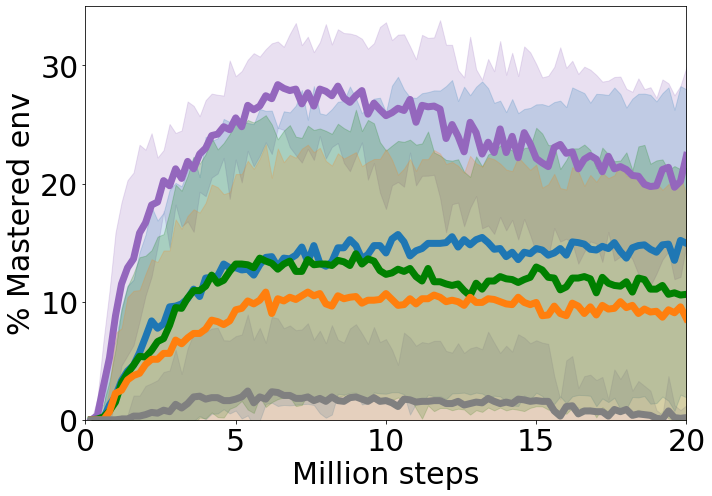

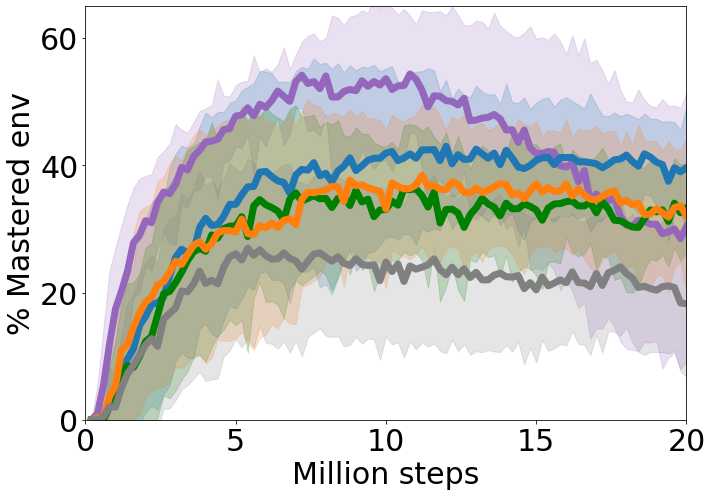

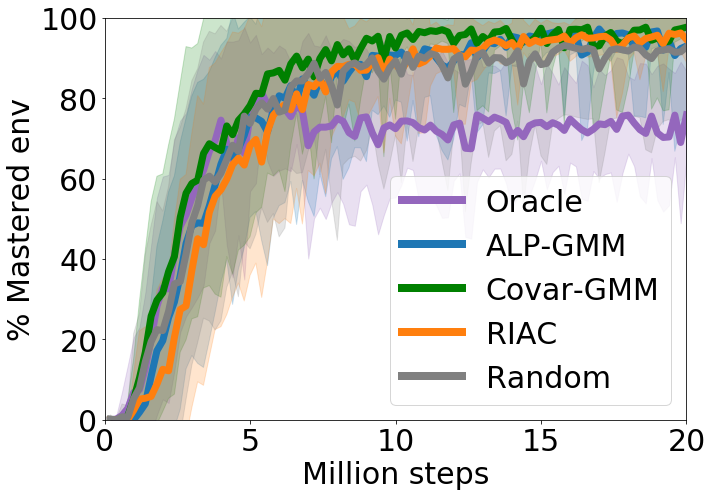

In [17]:
# SIMPLE EXPE

#order = ['oracle','gmm','riac','rand']
agent_types = ["short","default", "long"]
legend = [False, False, True]
y_max = [35,65,100]
plt.ion()
for k, a_type in enumerate(agent_types):
    f, ax = plt.subplots(1,1,figsize=(10,7))
    ax = [ax]
    for i,(m_id,label) in enumerate(labels.items()):
        if "nmm" in m_id:
            continue
        if a_type in m_id:
            print(m_id)
            runs_data = models_saves[m_id]['data']
            ys = []
            for run in runs_data:  
                data = run['nb_mastered']
                #data=run['evaluation return']
                #print(run['config']['seed'])
                #print("max:{} last:{}".format(max(data), data[-1]))

                episodes = np.array(run['total timesteps'])
                ys.append(data)
            #clean data    
            min_len = 999999
            for y in ys:
                if len(y) < min_len:
                    
                    min_len = len(y)
            ys_same_len = []
            for y in ys:
                ys_same_len.append(y[0:min_len])
            print("{} +- {}".format(np.round(np.mean(ys_same_len,axis=0)[-1], 1),
                                    np.round(np.std(ys_same_len,axis=0)[-1], 1)))
            episodes = episodes[0:min_len]
            episodes = [e/1000000 for e in episodes]
            if "gmm" in m_id or "bmm" in m_id:
                #print(m_id)
                last_p = []
#                 for y in ys_same_len:
#                     last_p.append(y[99])
#                 get_percentiles(np.array(last_p), m_id, max_ep=99)

#             plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
#                                 title="Median BW stump width/height/rotation/spacing {} agent".format(a_type), legend=True)
            plot_with_std(0, ax[0],episodes,np.mean(ys_same_len,axis=0),np.std(ys_same_len,axis=0),
                          colors[m_id],colors[m_id],label, legend=legend[k],ylim=[0,y_max[k]])
            plt.tight_layout()
            #f.savefig('graphics/final/corl_simple_exp_{}.svg'.format(a_type))
            #f.savefig('graphics/final/corl_simple_exp_{}.pdf'.format(a_type))
#all_perfs_gmm_variants_{}_agents_mastered_envs
# perform welch tests:

for type0 in agent_types:
    for i0,(m_id0,label0) in enumerate(labels.items()):
        if type0 in m_id0:
            for i1,(m_id1,label1) in enumerate(labels.items()):
                if type0 in m_id1:
                    get_welch(algo_0=m_id0, algo_1=m_id1, epoch=100)
# for l in labels.keys():
#     if 'short' in l:
#         get_welch(algo_0='gmmcshortcpu20-07', algo_1=l)
# for l in labels.keys():
#     if 'default' in l:
#         get_welch(algo_0='gmmcdefaultaic20-07', algo_1=l)
# get_welch(algo_0='gmmcshortaic2k07-08', algo_1="bmmcshort15-08")
# get_welch(algo_0='gmmcdefaultaic2k07-08', algo_1="bmmcdefault15-08")
# get_welch(algo_0='gmmclongaic2k07-08', algo_1="bmmclong15-08")
# get_welch(algo_0='gmmcontlong09-06', algo_1="randcontlong09-06")
# get_welch(algo_0='gmmcontdefault08-06', algo_1="riaccontdefault08-06")
# get_welch(algo_0='gmmpolylong17-06', algo_1='randpolylong17-06')
# get_welch(algo_0='gmmpolydefault17-06', algo_1='randpolydefault17-06')
# get_welch(algo_0=, algo_1='gmmpolylong17-06')     
#plt.savefig("graphics/sac_sagg_vs_random_3_leg_sizes.png", bbox_inches='tight') 

OrderedDict([('gmmplongaic2k02-09', '#1f77b4'), ('randplong19-09', 'grey'), ('oracleplongcpu19-09', '#9467bd'), ('bmmplongcpu02-09', 'green'), ('riacplong19-09', '#ff7f0e')])
oracleplongcpu19-09
zeros: 0/32
max zeros: 0/32
oracleplongcpu19-09 -> percentile: [62.  74.  80.5]
68.3125
gmmplongaic2k02-09
zeros: 0/32
max zeros: 0/32
gmmplongaic2k02-09 -> percentile: [81.5 90.  94. ]
80.4375
bmmplongcpu02-09
zeros: 8/32
max zeros: 1/32
bmmplongcpu02-09 -> percentile: [10.5 78.  94. ]
57.625
riacplong19-09
zeros: 5/32
max zeros: 0/32
riacplong19-09 -> percentile: [ 9.  65.  90.5]
52.0
randplong19-09
zeros: 16/26
max zeros: 0/26
randplong19-09 -> percentile: [ 0.   0.  44.5]
22.46153846153846
odict_values(['Oracle', 'ALP-GMM', 'Covar-GMM', 'RIAC', 'Random'])
['#9467bd', '#1f77b4', 'green', '#ff7f0e', 'grey']
algo0:gmmplongaic2k02-09, algo1:bmmplongcpu02-09
welch Ttest_indResult(statistic=2.7698450250352185, pvalue=0.007916752075139704)
algo0:gmmplongaic2k02-09, algo1:riacplong19-09
welch Ttest

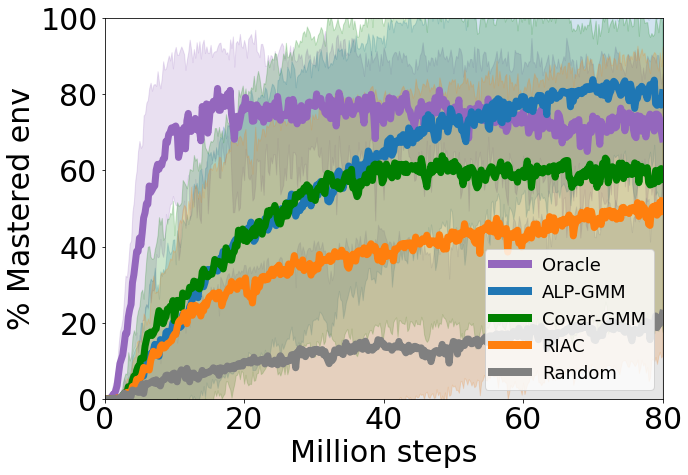

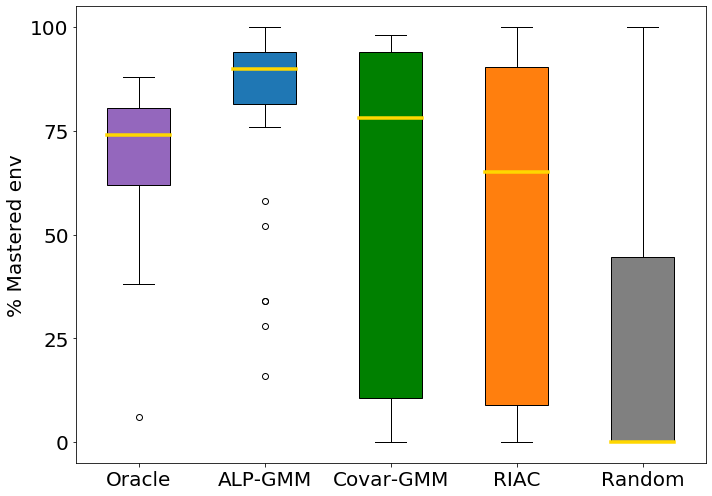

In [116]:
# HEXAGON TRACKS EXPE

print(colors)
#Increasing stump height experience
#agent_types = ["cd","h4","h5"]
agent_types = ['pl']
#agent_types = ['sl']
plt.ion()
for a_type in agent_types:
    f, ax = plt.subplots(1,1,figsize=(10,7))
    f2, ax2 = plt.subplots(1,1,figsize=(10,7))
    ax = [ax]
    ax2 = [ax2]
    boxplot_data = []
    for i,(m_id,label) in enumerate(labels.items()):
        if a_type in m_id: #and 'oracle' not in m_id:
            print(m_id)
            runs_data = models_saves[m_id]['data']
            ys = []
            for run in runs_data:  
                #print(run['config']['seed'])
                #print(run['config']['seed'])
                data = run['nb_mastered']
                #data = run['evaluation return']
                episodes = np.array(run['total timesteps'])
                ys.append(data)
            #clean data    
            min_len = 999
            for y in ys:
                if len(y) < min_len:
                    
                    min_len = len(y)
            ys_same_len = []
            for y in ys:
                ys_same_len.append(y[0:min_len])
            episodes = episodes[0:min_len]
            episodes = [e/1000000 for e in episodes]
            #print(episodes)
            if agent_types[0] == 'sl':
                ylim = [0,40]
            else:
                ylim = [0,100]
            last_p = []
            max_p = []
            for y in ys_same_len:
                last_p.append(y[399])
                max_p.append(np.max(y))
                
            #print(last_p)
            print("zeros: {}/{}".format(len(last_p) - np.count_nonzero(last_p), len(last_p)))
            print("max zeros: {}/{}".format(len(max_p) - np.count_nonzero(max_p), len(last_p)))
            print('{} -> percentile: {}'.format(m_id, np.percentile(last_p,[25,50,75])))

#             plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
#                                  legend=True)
            print(np.mean(ys_same_len,axis=0)[-1])
            plot_with_std(0, ax[0],episodes,np.mean(ys_same_len,axis=0),
                          np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                           legend=True, leg_size=18, leg_loc='lower right', ylim=ylim, xlim=[0,80])

            # format data for boxplot:
            median = np.median(np.array(ys_same_len), axis=0)
            last_ys = [y[-1] for y in ys_same_len]
            pers = np.percentile(last_ys,[25,50,75])
            boxplot_data.append((last_ys, pers[1], pers[0],pers[2]))
            
    
            plt.tight_layout()
            f.savefig('graphics/final/hexagon_exps.pdf')
            f.savefig('graphics/final/hexagon_exps.svg')
        
    plot_boxplot(boxplot_data, labels.values(),
                 ax2[0],[colors[k] for k in labels.keys()])
    plt.tight_layout()
    f2.savefig('graphics/final/hexagon_boxplot.pdf')
    f2.savefig('graphics/final/hexagon_boxplot.svg')

# perform welch tests:
# for type0 in ['pl','cd','h4','h5']:
#     for i0,(m_id0,label0) in enumerate(labels.items()):
#         if type0 in m_id0 and 'riac' in m_id0:
#             for i1,(m_id1,label1) in enumerate(labels.items()):
#                 if type0 in m_id1 and 'gmm' in m_id1:
#                     get_welch(algo_0=m_id0, algo_1=m_id1, epoch=200)
# get_welch(algo_0='gmmplong3k20-07', algo_1='riacplong22-06',epoch=200)
# get_welch(algo_0='oracleplong25-06', algo_1='gmmplong3k20-07',epoch=200)
# get_welch(algo_0='gmmslongaic3k27-07', algo_1='randslong23-07')
# get_welch(algo_0='gmmslongaic3k27-07', algo_1='riacslong20-07')
#get_welch(algo_0='gmmplongaic2k02-09', algo_1='oracleplongcpu02-09')
get_welch(algo_0='gmmplongaic2k02-09', algo_1='bmmplongcpu02-09')
get_welch(algo_0='gmmplongaic2k02-09', algo_1='riacplong19-09')
get_welch(algo_0='gmmplongaic2k02-09', algo_1='oracleplongcpu19-09')

get_welch(algo_0='oracleplongcpu19-09', algo_1='bmmplongcpu02-09')
get_welch(algo_0='oracleplongcpu19-09', algo_1='riacplong19-09')
get_welch(algo_0='riacplong19-09', algo_1='randplong19-09')
#get_welch(algo_0='gmmplongaic2k02-09', algo_1='riacplong19-08')

OrderedDict([('gmmplongaic2k02-09', '#1f77b4'), ('randplong19-09', 'grey'), ('oracleplongcpu19-09', '#9467bd'), ('bmmplongcpu02-09', 'green'), ('riacplong19-09', '#ff7f0e')])
SELF COMPARISONS:
COMPARISONS TO OTHERS:


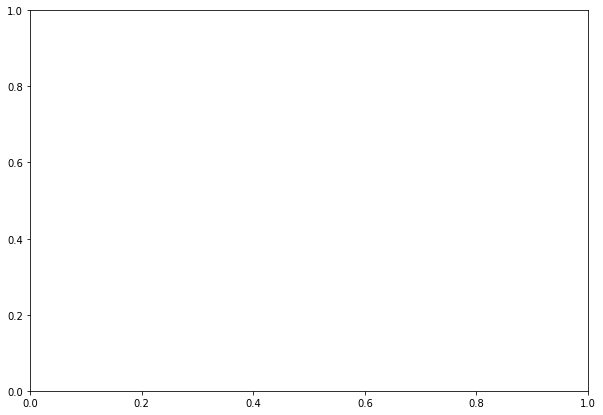

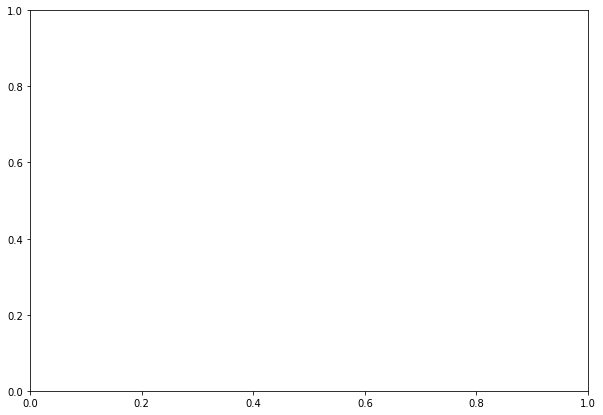

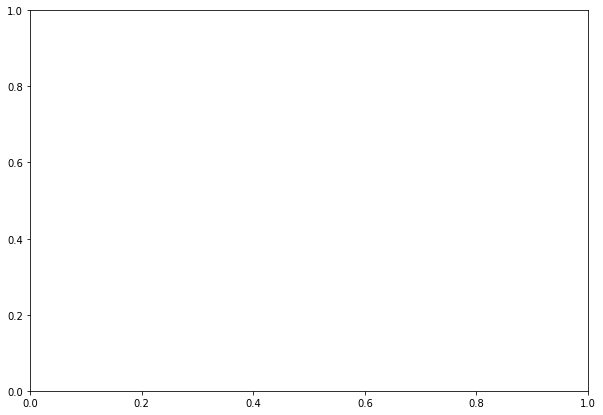

In [112]:
# UNFEASIBILITY EXPES

print(colors)
#Increasing stump height experience
agent_types = ["cd","h4","h5"]
legend = [False, False, True]
plt.ion()
for k, a_type in enumerate(agent_types):
    f, ax = plt.subplots(1,1,figsize=(10,7))
    ax = [ax]
    for i,(m_id,label) in enumerate(labels.items()):
        if a_type in m_id: #and 'oracle' not in m_id:
            print(m_id)
            runs_data = models_saves[m_id]['data']
            ys = []
            for run in runs_data:  
                #print(run['config']['seed'])
                #print(run['config']['seed'])
                data = run['nb_mastered']
                #data = run['evaluation return']
                episodes = np.array(run['total timesteps'])
                ys.append(data)
            #clean data    
            min_len = 999
            for y in ys:
                if len(y) < min_len:
                    
                    min_len = len(y)
            ys_same_len = []
            for y in ys:
                ys_same_len.append(y[0:min_len])
            episodes = episodes[0:min_len]
            episodes = [e/1000000 for e in episodes]
            #print(episodes)
            if agent_types[0] == 'sl':
                ylim = [0,40]
            else:
                ylim = [0,100]
            print("{} +- {}".format(np.round(np.mean(ys_same_len,axis=0)[-1], 1),
                                    np.round(np.std(ys_same_len,axis=0)[-1], 1)))
            
#             plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
#                                  legend=True)
            plot_with_std(0, ax[0],episodes,np.mean(ys_same_len,axis=0),
                          np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                           legend=legend[k],ylim=[0,60], xlim=[0,20])
            plt.tight_layout()
            #f.savefig('graphics/bmm_comparison_hexagon_env.png'.format(a_type))
            f.savefig('graphics/final/stump_tracks_{}_agents_mastered_envs.pdf'.format(a_type))
            f.savefig('graphics/final/stump_tracks_{}_agents_mastered_envs.svg'.format(a_type))

# #perform welch tests:
# for type0 in ['cd','h4','h5']:
#     for i0,(m_id0,label0) in enumerate(labels.items()):
#         if type0 in m_id0:
#             for i1,(m_id1,label1) in enumerate(labels.items()):
#                 if type0 in m_id1: #and 'gmm' in m_id1:
#                     get_welch(algo_0=m_id0, algo_1=m_id1)

                    
print('SELF COMPARISONS:')
for type0 in ['cd','h4','h5']:
    for i0,(m_id0,label0) in enumerate(labels.items()):
        if type0 in m_id0:
            for i1,(m_id1,label1) in enumerate(labels.items()):
                if type0 not in m_id1 and (('gmmcde' in m_id0 and 'gmm' in m_id1)or
                 ('bmmcde' in m_id0 and 'bmm' in m_id1)or
                 ('riaccde' in m_id0 and 'riac' in m_id1)or
                 ('randcde' in m_id0 and 'rand' in m_id1)): #and 'gmm' in m_id1:
                    get_welch(algo_0=m_id0, algo_1=m_id1)

print('COMPARISONS TO OTHERS:')
for type0 in ['cd','h4','h5']:
    for i0,(m_id0,label0) in enumerate(labels.items()):
        if type0 in m_id0:
            for i1,(m_id1,label1) in enumerate(labels.items()):
                if type0 in m_id1: #and 'gmm' in m_id1:
                    get_welch(algo_0=m_id0, algo_1=m_id1)

In [ ]:
#single plot
plt.ion()
f, ax = plt.subplots(1,1,figsize=(10,7))
ax = [ax]
fm, axm = plt.subplots(1,1,figsize=(10,7))
axm = [axm]
for i,(m_id,label) in enumerate(labels.items()):
    #print(m_id)
    runs_data = models_saves[m_id]['data']
    #print(len(runs_data))
    ys = []
    for run in runs_data:  
        #print(list(run))
        data = run['nb_mastered']
        #data = run['AverageEpRet']
        #print(list(run))
        episodes = np.array(run['total timesteps'])
        #print(run['config']['seed'])
        #print(len(run['env_params_train']))
        #print(len(run['env_params_test']))
        ys.append(data)
        #clean data    
    min_len = 999999
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    ys_same_len = []
    for y in ys:
        ys_same_len.append(y[0:min_len])
    episodes = episodes[0:min_len]
    episodes = [e/1000000 for e in episodes]
    
#     plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
#                         title="BW (stumps[0,3],spacing[0,6]) all levels", legend=True)
    #f.savefig('graphics/sac_sagg_vs_random_3_leg_sizes.png')
    plot_with_std(0, axm[0],episodes,np.mean(ys_same_len,axis=0),np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                   legend=False,ylim=[0,55])

#get_welch(algo_0='saggcont02-05', algo_1="randcont02-05")
        
#plt.savefig("graphics/sac_sagg_vs_random_3_leg_sizes.png", bbox_inches='tight')

In [99]:
a = np.random.random(20)
b = np.random.random(30)
print(a)
plt.boxplot([a,b], labels=['a','bb'], colors=["blue","green"])

[0.84736288 0.05051492 0.57943474 0.1530955  0.12197617 0.24909417
 0.16413519 0.61262584 0.287901   0.13366467 0.32859622 0.81963291
 0.51253459 0.03586826 0.9554013  0.01985964 0.16887376 0.1007314
 0.69514166 0.77168488]


TypeError: boxplot() got an unexpected keyword argument 'colors'

In [ ]:
# FOR GMM COMPLEX POLY ENV TASK SAMPLING VIZU
import gym
import gym_flowers
def poly_params_to_image(p):
    env = gym.make('flowers-Walker-continuous-v0')  # 4242 gap 42 stump #'flowers-Walker-v2''BipedalWalkerHardcore-v2''OGWalkerHardcore-v2'
    env.env.my_init({'leg_size': 'long'})
    env.env.set_environment(poly_shape=p)
    env.reset()
    img = env.render(mode='rgb_array')
    env.close()
    return img

def poly_2_stump_height(params):
    scaling = 14/30.0
    obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
    paired_params = [[params[i],params[i+1]] for i in range(0,len(params),2)]
    #print(paired_params)
    # first recover polygon coordinate
    poly_coord = []
    for i,(b,d) in enumerate(zip(obstacle_polygon, paired_params)):
        #print(paired_params)
        if i != 0 and i != (len(obstacle_polygon)-1):
            poly_coord.append([(b[0]*scaling) + (d[0]*scaling),
                              (b[1]*scaling) + (d[1]*scaling)])
        else:
            poly_coord.append([(b[0] * scaling) + (d[0]*scaling),
                               (b[1] * scaling)])
    # the find maximal width and height
    poly_coord = np.array(poly_coord)
    min_x = np.min(poly_coord[:,0])
    max_x = np.max(poly_coord[:,0])
    min_y = np.min(poly_coord[:,1])
    max_y = np.max(poly_coord[:,1])
    return [(max_x - min_x)/scaling, (max_y - min_y)/scaling]
        
def plt_2_rgb(ax):
    ax.figure.canvas.draw()
    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    return data

import imageio

# def extract_env_params(env_goals, order=['poly_ss']):
#     #order = ['stump_hs', 'tunnel_hs']
#     if order == ['poly_ss']:
#         flat_env_params = copy.copy(env_goals[order[0]])
#         # map to 2d height and width
#         scaling = 14/30.0
#         obstacle_polygon = [(-0.5,0),(-0.5,0.25),(-0.25,0.5),(0.25,0.5),(0.5,0.25),(0.5,0)]
#         height_width_params = []
#         for params in flat_env_params:
#             height_width_params.append(poly_2_stump_height(params))
#         return height_width_params
# FIXED SET PERFS VIZU
size_test_set = 50
mastered_thr = 230
max_epochs = 100

stats = {}
for i,(m_id,label) in enumerate(labels.items()):
    if "gmmplong" not in m_id:
        continue
    print(m_id)
    runs_data = models_saves[m_id]['data']
    #collect raw perfs
    for r,run in enumerate(runs_data):
        if r is not 1:
            continue
        poly_tasks_dict = run['env_params_train']
        poly_tasks_list = [p for p in poly_tasks_dict['poly_ss']]
        poly_rewards = run['env_train_rewards']
        hw_tasks = np.array([poly_2_stump_height(p) for p in poly_tasks_list])
        plt.ion()
        
        print(len(run['means']))
        for j,m_vec in enumerate(run['means']):
            best_params = []
            best_lp = -1
            for p in m_vec:
                if p[-1] > best_lp:
                    best_params = p[:-1]
                    best_lp = p[-1]
            img = poly_params_to_image(best_params)
            plt.imsave('best_gmm({})_{}.png'.format(j,len(m_vec)), img)
#             plt.figure()
#             plt.imshow(img)
#         mean_rews = [np.mean(poly_rewards[i:i+250]) for i in range(250,len(poly_rewards),250)]
#         plt.plot(mean_rews)
#         plt.figure()
#         heatmap, xedges, yedges = np.histogram2d(hw_tasks[:30000,0], hw_tasks[:30000,1],
#                                                      bins=50,
#                                                     range=[[0,5],[0,5]])
#         extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#         plt.imshow(heatmap.T, extent=extent, origin='lower')
#         plt.savefig("graphics/VIZUmiddle_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))
#         plt.show()
        
        
        
        if False:
            start = 0
            end = 30000
            step = 250
            nb_points = 250
            images = []
            f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,4))
            ax = (ax0, ax1)
            for k,i in enumerate(range(start,end,step)):
                ax0.plot(mean_rews[:k+1])
                ax0.set_ylim(top=300, bottom=-150)
                ax0.set_xlim(left=0, right=150)

                heatmap, xedges, yedges = np.histogram2d(hw_tasks[i:i+step,0], hw_tasks[i:i+step,1],
                                                         bins=20,
                                                        range=[[0,5],[0,5]])
                extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

                ax1.imshow(heatmap.T, extent=extent, origin='lower')

    #             print(i)
    #             plt.figure(figsize=(8,8))
    #             ax = plt.gca()

    #             for j in range(nb_points):
    # #                 print(poly_rewards[i+j])
    # #                 print(type(np.interp(poly_rewards[i+j],[-150,350],[0,1])))
    #                 #color = plt.cm.jet(np.interp(poly_rewards[i+j],[-150,350],[0,1]))
    # #                 print(color)
    # #                 print(type(color)
    #                 if poly_rewards[i+j] > 230:
    #                     ax.scatter(hw_tasks[i+j][0], hw_tasks[i+j][1],
    #                                c='green', s=50, zorder=2)
    #                 else:
    #                     ax.scatter(hw_tasks[i+j][0], hw_tasks[i+j][1],
    #                                c='red', s=50, zorder=2)

    #             ax.set_xlim(left=0,right=6)
    #             ax.set_ylim(top=6, bottom=0)
    #             ax.tick_params(axis='both', which='major', labelsize=20)
    #             ax.set_xlabel('hexagon width', fontsize=25)
    #             ax.set_ylabel('hexagon height', fontsize=25)
    #             ax.set_aspect('equal', 'box')
    #             plt.tight_layout()
    #             #plt.show()
                images.append(plt_2_rgb(plt.gca()))
    #             plt.close()
            imageio.mimsave('graphics/complex_{}_evo_42.gif'.format(m_id), images, duration=0.3)
        
        #plt.savefig("graphics/gmmcomplex_triptic_{}_{}.png".format(m_id,runs_data[r]['config']['seed']))

In [154]:
import matplotlib.patches as patches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.colorbar as cbar
      
def plot_regions(boxes, interests, ax=None, xlim=[0,2], ylim=[0,2]):
    # Create figure and axes
    if ax==None:             
        f, ax = plt.gca()
    # Add the patch to the Axes
    for b,ints in zip(boxes,interests):
        #print(b)
        lx,ly = b.low
        hx,hy = b.high
        c = plt.cm.jet(ints)
        rect = patches.Rectangle([lx,ly],(hx - lx),(hy - ly),linewidth=3,edgecolor='white',facecolor=c)
        ax.add_patch(rect)
        #plt.Rectangle([lx,ly],(hx - lx), (hy - ly))

    cax, _ = cbar.make_axes(ax) 
    cb = cbar.ColorbarBase(cax, cmap=plt.cm.jet) 
    cb.set_label('Mean Competence Progress')
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(ymin=ylim[0],ymax=ylim[1])
    ax.axis('equal')
    ax.set_xlabel('stump height', fontsize=20)
    ax.set_ylabel('stump_spacing', fontsize=20)

def region_plot_gif(all_boxes, interests, iterations, goals,
                    gifname='saggriac', rewards=None, ep_len=None,
                    xlim=[0,2], ylim=[0,2], fs=(18,7), plot_step=250):
    plt.ioff()
    print("Making an exploration GIF: "+gifname)
    filenames = []
    images = []
    steps = []
    mean_rewards = []
    for i in range(len(goals)):
        if i>0 and (i%plot_step == 0):
            f, (ax0,ax1) = plt.subplots(1,2,figsize=fs)
            ax = [ax0,ax1]
            scatter_plot(goals[0:i], ax=ax[0], emph_data=goals[i-plot_step:i], xlim=xlim, ylim=ylim)
            idx = 0
            cur_idx = 0
            for j in range(len(all_boxes)):
                if iterations[j] > i:
                    break
                else:
                    cur_idx = j

#             #ADD TRAINING CURVE
#             ax[2].set_ylabel('Train return', fontsize=18)
#             steps.append(sum(ep_len[0:i]))
#             mean_rewards.append(np.mean(rewards[i-plot_step:i]))
#             ax[2].plot(steps,mean_rewards)
            
            plot_regions(all_boxes[cur_idx], interests[cur_idx],ax=ax[1], xlim=xlim, ylim=ylim)
            f_name = "graphics/gifs/scatter_{}.png".format(i)
            plt.suptitle('Episode {}'.format(i), fontsize=20)
            plt.savefig(f_name, bbox_inches='tight')
            plt.close(f)
            filenames.append(f_name)
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/{}.gif'.format(gifname), images, duration=0.3)

def extract_env_params(env_goals, order):
    #order = ['stump_hs', 'tunnel_hs']
    flat_env_params = copy.copy(env_goals[order[0]])
    nb_episodes = len(flat_env_params)
    if len(order) == 1:
        pass #work already done
    elif order == ['stump_hs', 'ob_sps']:
        for ep_nb in range(nb_episodes):
                flat_env_params[ep_nb][1] = env_goals['ob_sps'][ep_nb] #ignore variance 
    elif len(order) == 2:
        for ep_nb in range(nb_episodes):
            for i in range(1,len(order)):
                flat_env_params[ep_nb][1] = env_goals[order[i]][ep_nb][0] #ignore variance 
        print(env_goals[order[0]][0])
        print(env_goals[order[1]][1])
        print(flat_env_params[0])
    return flat_env_params

def scatter_plot_gif(data,nb_steps=50, name='test', xlim=None, ylim=None, fs=(7,7)):
    plt.ioff()
    length = len(data)
    step_size = int(length / nb_steps)
    print("Making an exploration GIF of {} steps".format(nb_steps))
    filenames = []
    for i,max_episodes in enumerate(np.arange(step_size,length+step_size,step_size)):
        scatter_plot(data[0:max_episodes],
                     emph_data=data[max_episodes-step_size:max_episodes],
                     xlim=xlim, ylim=ylim, fs=fs)
        f_name = "graphics/gifs/scatter_{}_{}.png".format(max_episodes, i)
        plt.xlim(xmin=xlim[0],xmax=xlim[1])
        plt.ylim(ymin=ylim[0],ymax=ylim[1])
        plt.savefig(f_name, bbox_inches='tight')
        plt.close(f)
        filenames.append(f_name)
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/scatter_gif_{}.gif'.format(name), images, duration=0.3)
        
def scatter_plot(data, ax=None, emph_data=None, xlim=[0,2], ylim=[0,2],fs=(7,7)):
    #print(ylim)
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=fs)
    Xs,Ys = [d[0] for d in data], [d[1] for d in data]
    if emph_data is not None:
        emphXs,emphYs = [d[0] for d in emph_data], [d[1] for d in emph_data]
    ax.plot(Xs,Ys,'r.',markersize=1)#2
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(ymin=ylim[0],ymax=ylim[1])
    if emph_data is not None:
        ax.plot(emphXs,emphYs,'b.',markersize=3)#5
    ax.set_xlabel('stump height', fontsize=20)
    ax.set_ylabel('spacing', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_aspect('equal', 'box')
  

oraclecdefaultcpu21-06
dict_keys(['stump_hs', 'stump_ws', 'stump_rs', 'tunnel_hs', 'ob_sps', 'poly_ss'])
[0.42440884863428935, 5.178895924920998]
None
dict_keys(['stump_hs', 'stump_ws', 'stump_rs', 'tunnel_hs', 'ob_sps', 'poly_ss'])
15
['stump_hs', 'ob_sps']


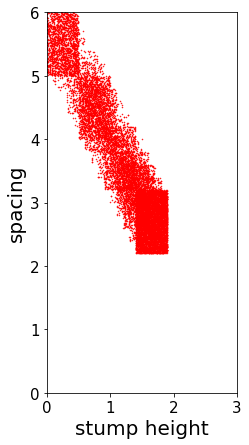

In [151]:
#PLOT scatter plots
for i,(m_id,d) in enumerate(models_saves.items()):
    if 'default' not in m_id:
        continue
    if 'oracle' not in m_id:
        continue
    print(m_id)
    runs_data = d['data']

    for j,run in enumerate(runs_data):
        if j!=0:
            continue
        d = run['env_params_train']
        print(d.keys())
        print(d['stump_hs'][0])
        print(d['tunnel_hs'][0])
        print(d.keys())
        print(run['config']['seed'])
        order = []
        if d['stump_hs'][0]:
            order.append('stump_hs')
        if d['tunnel_hs'][0]:
            order.append('tunnel_hs')
        if d['ob_sps'][0]:
            order.append('ob_sps')
        print(order)
        
        scatter_plot(extract_env_params(d, order), xlim=[0,3], ylim=[0,6])
        plt.show()
            
#         scatter_plot_gif(extract_env_params(d, order),
#                           name='{}{}'.format(m_id, j), xlim=[0,3], ylim=[0,6])


oraclecdefaultcpu21-06
15304
['stump_hs', 'ob_sps']


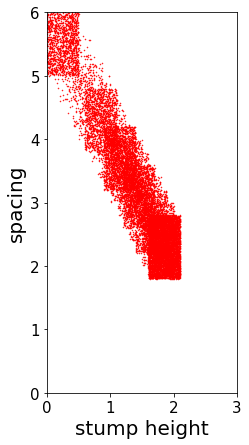

Making an exploration GIF of 50 steps


/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


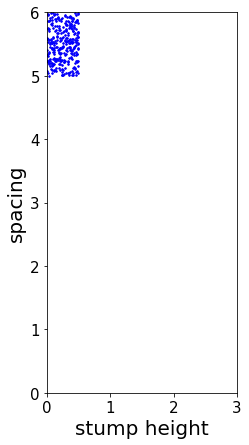

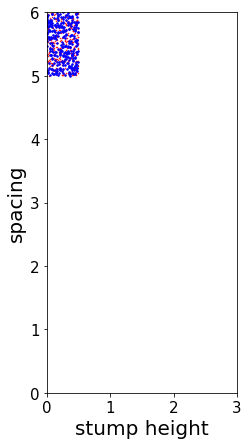

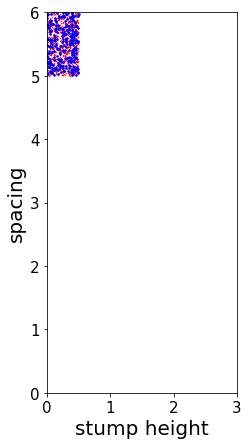

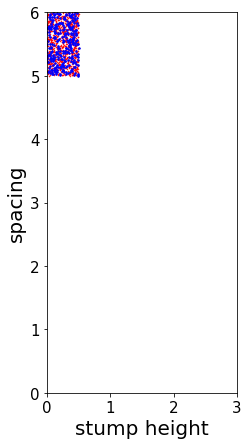

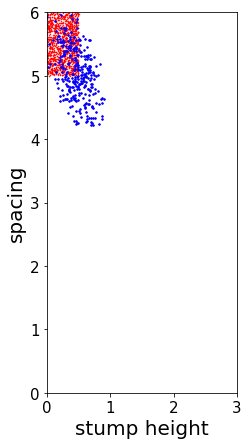

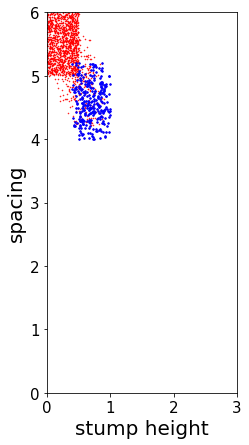

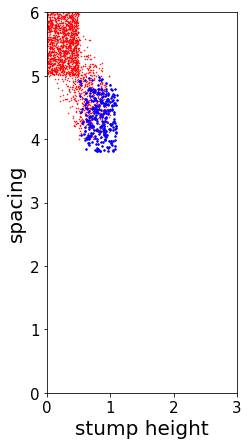

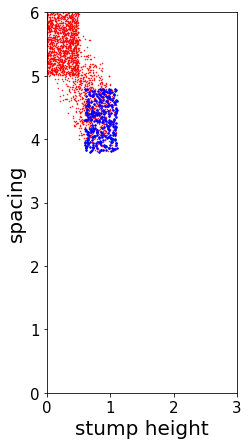

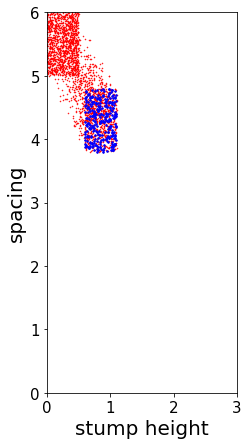

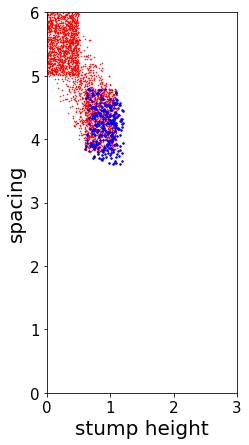

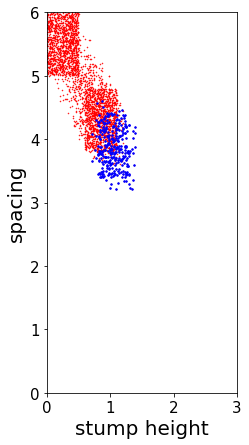

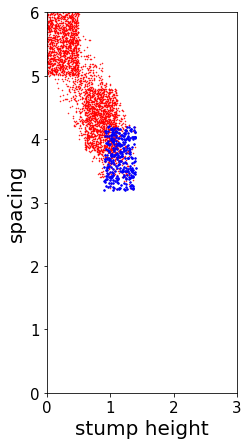

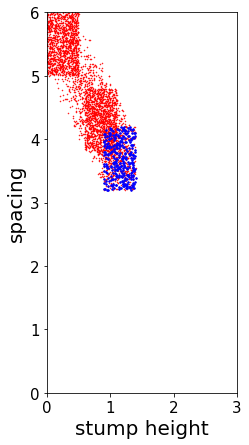

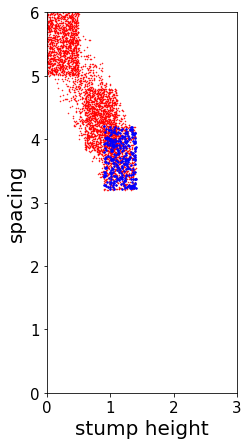

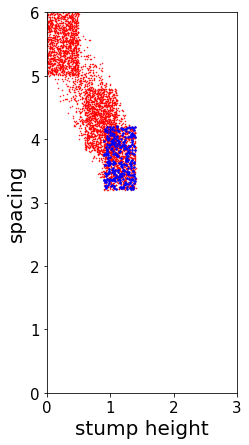

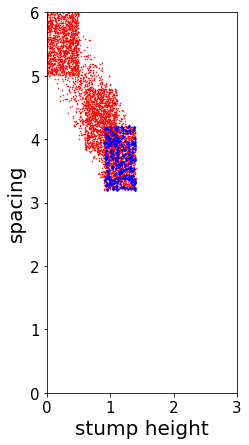

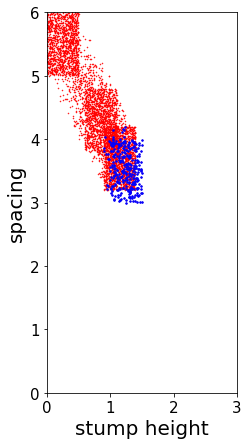

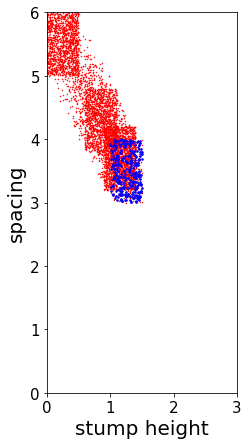

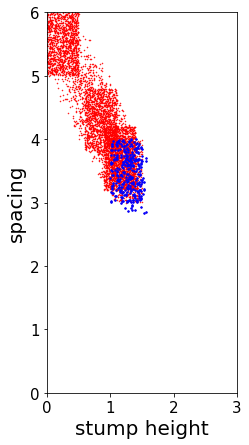

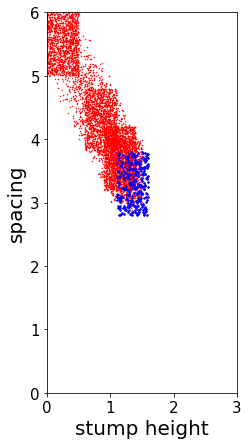

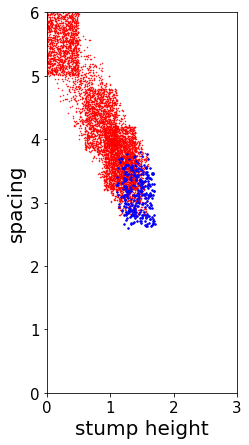

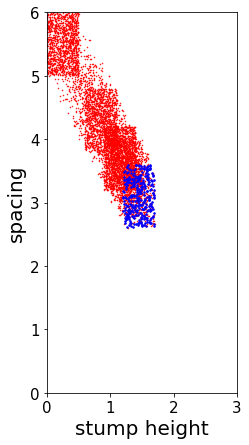

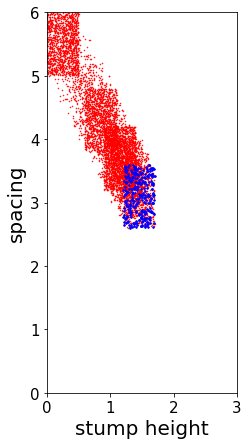

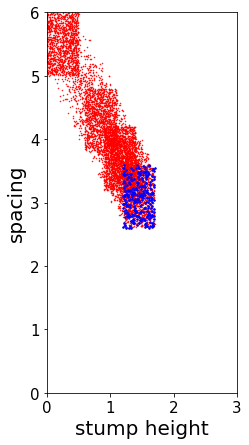

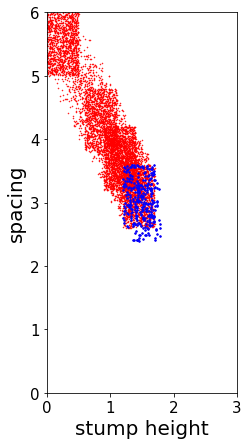

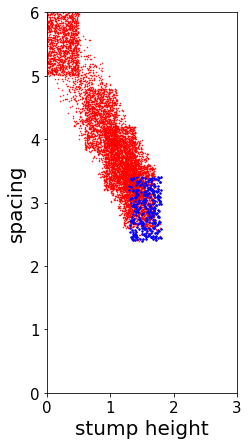

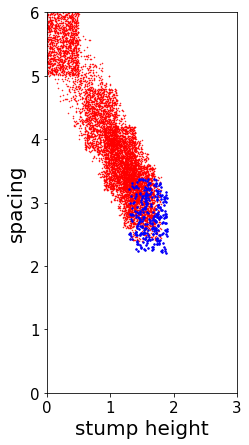

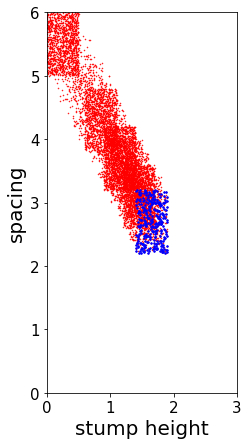

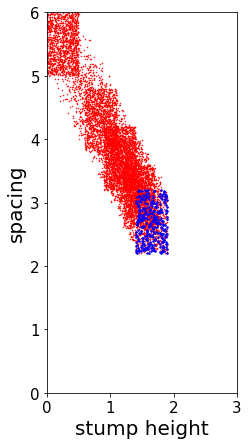

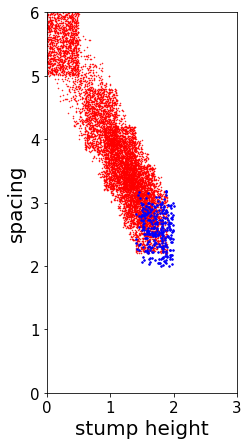

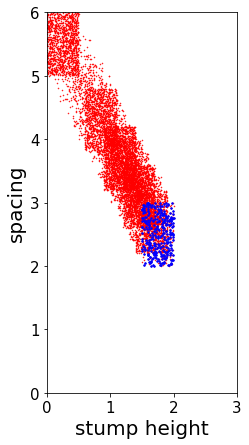

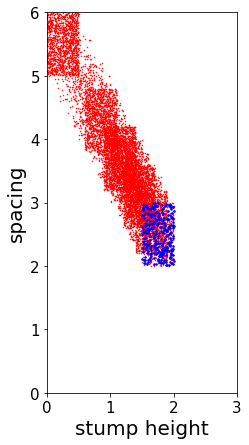

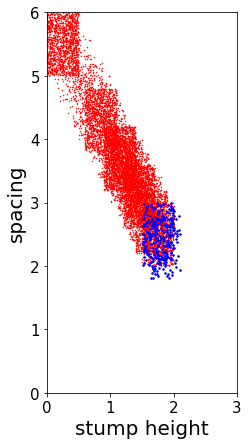

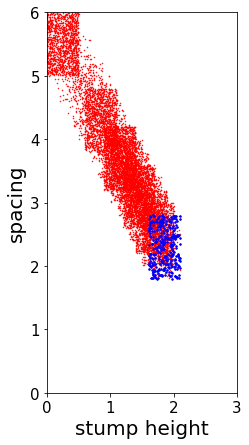

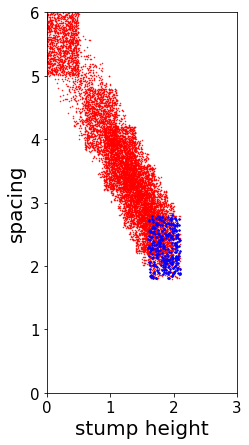

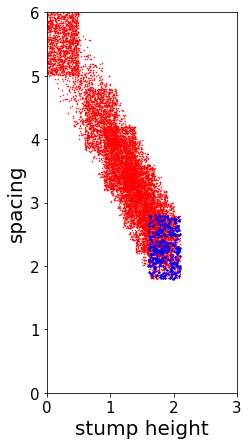

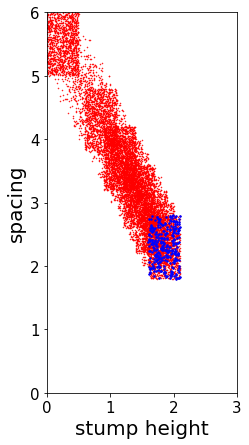

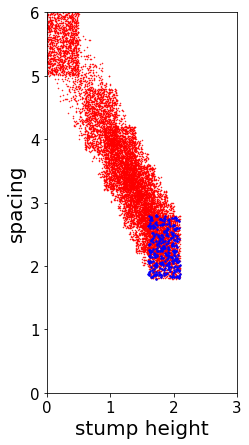

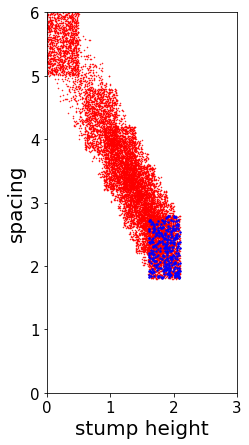

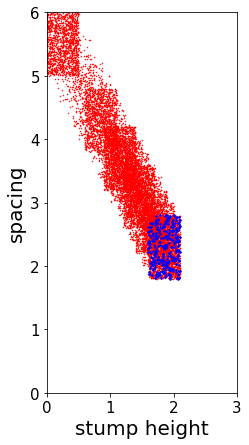

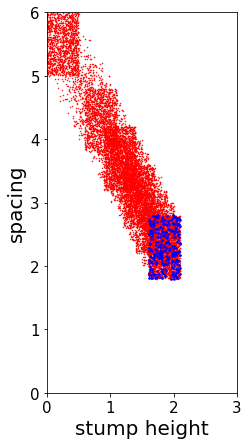

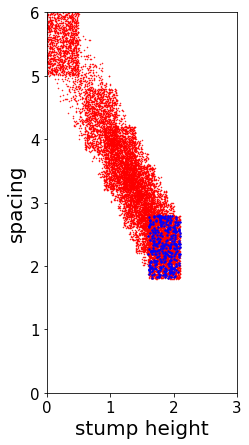

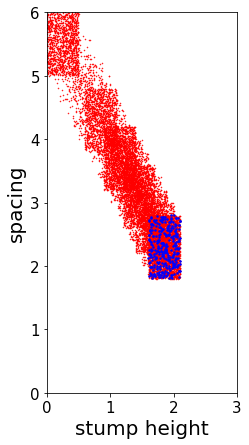

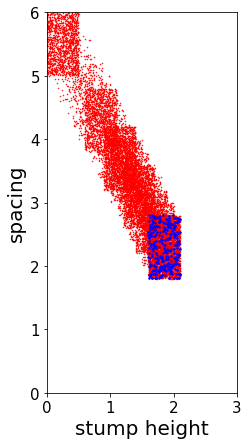

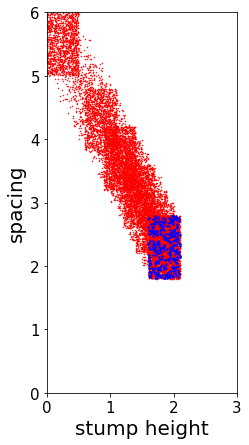

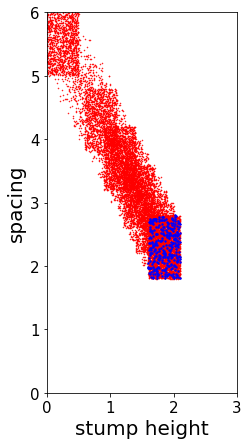

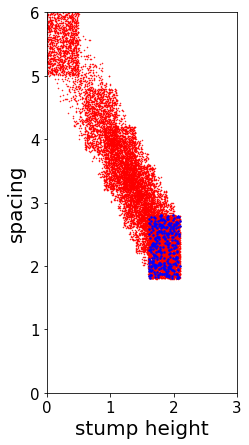

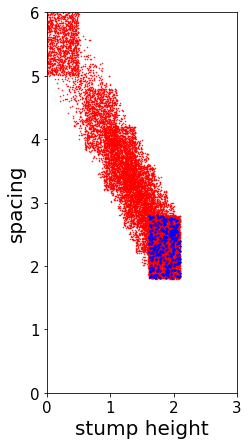

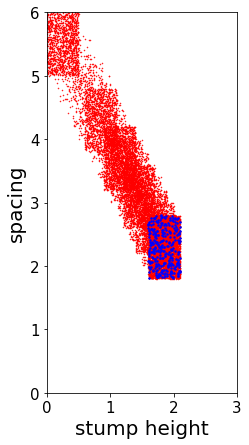

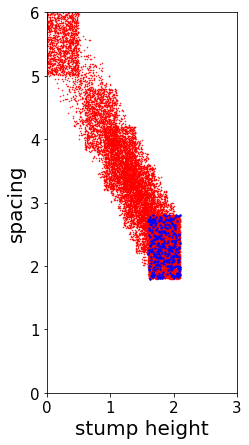

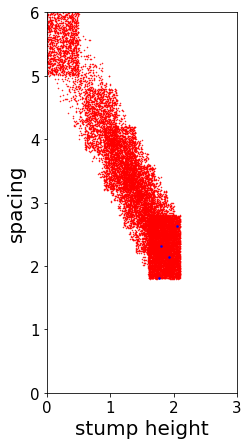

In [156]:
# Quadriptic Oracle
plt.ion()
for i,(m_id,d) in enumerate(models_saves.items()):
    if 'default' not in m_id:
        continue
    if 'oracle' not in m_id:
        continue
    print(m_id)
    runs_data = d['data']

    for j,run in enumerate(runs_data):
        if j != 11:
            continue
        d = run['env_params_train']
#         print(d.keys())
        print(len(d['stump_hs']))
#         print(d.keys())
#         print(run['config']['seed'])
        order = []
        if d['stump_hs'][0]:
            order.append('stump_hs')
        if d['tunnel_hs'][0]:
            order.append('tunnel_hs')
        if d['ob_sps'][0]:
            order.append('ob_sps')
        print(order)
        
        scatter_plot(extract_env_params(d, order), xlim=[0,3], ylim=[0,6])
        plt.show()
        
        scatter_plot_gif(extract_env_params(d, order),
                          name='{}{}'.format(m_id, j), xlim=[0,3], ylim=[0,6])



In [ ]:
# Triptic GMM and RIAC plots
import param_env_utils.imgep_utils.plot_utils as plotter
import importlib
importlib.reload(plotter)
save_dir = 'graphics/'
gmm_seed = 0
gmm_iterations = [500, 1500, 15000]
no_y = [True, True, False]
bars = [True,False,False]

riac_iterations = [1000,2250,7000,12000]
riac_bars = [False, False, False, True]
riac_nb = 2

#scatter_plot(env_goals)
for model_name,_ in models_saves.items():
    if not "default" in model_name:
        continue
    print(models_saves[model_name]['data'][0]['config']['env_babbling'])
    #print(models_saves[sagg_model_name]['data'][0]['config']['seed'])
    if models_saves[model_name]['data'][0]['config']['env_babbling'] == 'sagg_riac':
        all_boxes = models_saves[model_name]['data'][riac_nb]['all_boxes']

        #for boxes in all_boxes:
        #    print(boxes)
        split_iterations = models_saves[model_name]['data'][riac_nb]['split_iterations']
        env_train_rewards = models_saves[model_name]['data'][riac_nb]['env_train_rewards']
        all_interests = models_saves[model_name]['data'][riac_nb]['all_interests']
        env_goals = models_saves[model_name]['data'][riac_nb]['env_params_train']
        ep_len = models_saves[model_name]['data'][riac_nb]['env_train_len']
        order = []
        if env_goals['stump_hs'][0]:
            order.append('stump_hs')
        if env_goals['ob_sps'][0]:
            order.append('ob_sps')
        if len(env_goals) >= 2:
            env_goals = extract_env_params(env_goals, order)
            print(len(env_goals))

        if len(all_boxes) == 0:
            print('abort {}'.format(i))
            continue
        print(len(env_goals))
        name='triptic_RIAC_'+ model_name +str(i)
        rewards=env_train_rewards,
        ep_len=ep_len
        xlim=[0,3]
        ylim=[0,6]
        fs=(16,8)
        plot_step = 1000
        interests = all_interests
        iterations = split_iterations
        goals = env_goals

        filenames = []
        images = []
        steps = []
        mean_rewards = []
        plot_step = 250
        cpt=-1
        for i in range(len(goals)):
            if i > 0 and (i % plot_step == 0) and i in riac_iterations:
                cpt+=1
                f, ax = plt.subplots(1, 1, figsize=(5, 8))
                #plotter.scatter_plot(goals[0:i], ax=ax[0], emph_data=goals[i - plot_step:i], xlim=xlim, ylim=ylim)
                idx = 0
                cur_idx = 0
                for j in range(len(all_boxes)):
                    if iterations[j] > i:
                        break
                    else:
                        cur_idx = j
                print(j)
                plotter.plot_regions(all_boxes[cur_idx], interests[cur_idx], ax=ax, xlim=xlim,
                                     ylim=ylim, bar=riac_bars[cpt])

                #f_name = gifdir+tmpdir+"scatter_{}.png".format(i)
                f_path = save_dir + name +"_{}.png".format(i)
                #plt.suptitle('Episode {}'.format(i), fontsize=20)
                plt.savefig(f_path, bbox_inches='tight')
                plt.show()
                    
    elif models_saves[model_name]['data'][0]['config']['env_babbling'] == 'gmmlkjh':
        #plt.ioff()
        bk = models_saves[model_name]['data'][gmm_seed]
        name='triptic_GMM_'+str(gmm_seed)
        xlim=[0,3]
        ylim=[0,6]
        
        old_ep = 0
        gen_size = int(len(bk['goals_lps']) / len(bk['episodes']))
        gs_lps = bk['goals_lps']
        cpt = -1
        for i,(ws, covs, means, ep) in enumerate(zip(bk['weights'], bk['covariances'], bk['means'], bk['episodes'])):
                if ep not in gmm_iterations:
                    continue
                cpt += 1
                fig_size = (4,8)
                if bars[cpt]:
                    fig_size = (5,8)
                    
                plt.figure(figsize=fig_size)
                ax = plt.gca()
                print(no_y[cpt])
                plotter.plot_gmm(ws, means, covs, np.array(gs_lps[ep:ep+gen_size]),
                         ax=ax, xlim=xlim, ylim=ylim, no_y=no_y[cpt],
                         bar=bars[cpt],bar_side='left')  #add gen_size to have gmm + the points that they generated, not they fitted
                f_path = save_dir + name +"_{}.png".format(ep)
                old_ep = ep
                plt.savefig(f_path, bbox_inches='tight')
                plt.show()

        # fig sizes: normal: (4.5,8) + 
        


In [ ]:
import param_env_utils.imgep_utils.plot_utils as plotter
import importlib
importlib.reload(plotter)
# GIF for algorithms

#scatter_plot(env_goals)
for model_name,_ in models_saves.items():
#     if not "default" in model_name:
#         continue
    print(models_saves[model_name]['data'][0]['config']['env_babbling'])
    #print(models_saves[sagg_model_name]['data'][0]['config']['seed'])
    if models_saves[model_name]['data'][0]['config']['env_babbling'] == 'sagg_riac':
        for i in range(len(models_saves[model_name]['data'])):
            all_boxes = models_saves[model_name]['data'][i]['all_boxes']

            #for boxes in all_boxes:
            #    print(boxes)
            split_iterations = models_saves[model_name]['data'][i]['split_iterations']
            env_train_rewards = models_saves[model_name]['data'][i]['env_train_rewards']
            all_interests = models_saves[model_name]['data'][i]['all_interests']
            env_goals = models_saves[model_name]['data'][i]['env_params_train']
            ep_len = models_saves[model_name]['data'][i]['env_train_len']
            #print(len(all_boxes))
            #print(len(split_iterations))
            #print(list(env_goals))
            #print(env_goals['stump_hs'][0])
            order = []
            if env_goals['stump_hs'][0]:
                order.append('stump_hs')
            if env_goals['tunnel_hs'][0]:
                order.append('tunnel_hs')
            if env_goals['ob_sps'][0]:
                order.append('ob_sps')
            if len(env_goals) >= 2:
                env_goals = extract_env_params(env_goals, order)
                print(len(env_goals))

            if len(all_boxes) == 0:
                print('abort {}'.format(i))
                continue
            print(len(env_goals))
            plotter.region_plot_gif(all_boxes, all_interests, split_iterations, env_goals,
                           gifname='SAGG_'+ model_name +str(i), rewards=env_train_rewards,
                            ep_len=ep_len, xlim=[0,3], ylim=[0,6], fs=(5,8),
                           plot_step = 250)
    elif models_saves[model_name]['data'][0]['config']['env_babbling'] == 'gmm':
        for i in range(len(models_saves[model_name]['data'])):
            bk = models_saves[model_name]['data'][i]
            # fig sizes: normal: (4.5,8) + 
            plotter.gmm_plot_gif(models_saves[model_name]['data'][i], gifname='GMM_'+ model_name +str(i),
                                xlim=[0,3],ylim=[0,6], fig_size = (5,8), save_imgs=True, title=True, bar=True,
                                gifdir='graphics/')


![](graphics/exploration0.gif)
![](graphics/exploration1.gif)


![SegmentLocal](graphics/gmm0.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet0.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet1.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet2.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet3.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet4.gif "competence")
![SegmentLocal](graphics/onlineSAGGbignet5.gif "competence")

In [ ]:
lidar = []
self.lidar[i].fraction = 1.0
            self.lidar[i].p1 = pos
            self.lidar[i].p2 = (
                pos[0] + math.sin(1.5*i/10.0)*LIDAR_RANGE,
                pos[1] - math.cos(1.5*i/10.0)*LIDAR_RANGE)

In [ ]:
# PLOT EVOLUTION OF GMM's NUMBER OF GAUSSIANS
for i,(m_id,label) in enumerate(labels.items()):
    if "gmm" not in m_id:
        continue
    print(m_id)
    #print(m_id)
    runs_data = models_saves[m_id]['data']
    #print(len(runs_data))
    ys = []
    for j,run in enumerate(runs_data): 
            last_perf = round(run["nb_mastered"][-1],1)
            max_perf = round(max(run["nb_mastered"]),1)
            perf_str = "last:{}, max:{}".format(last_perf, max_perf)
            title = "Last perf: {}% | Max perf: {}%".format(last_perf, max_perf)
            print(perf_str)
            ax = plt.gca()
            nb_gauss = []
            for means in run['means']:
                nb_gauss.append(len(means))
            ax.plot(nb_gauss)
            ax.set_xlim(left=0)
            ax.set_ylim(top=10,bottom=1)
            
            ax.set_title(title, fontsize=15)
            plt.tight_layout()
#             plt.savefig("graphics/nb_gaussians/{}{}_{}.png"
#                         .format(m_id, j, perf_str))
            plt.show()
            plt.close()
            
        